# Reproducing Figure 6

In [1]:
###################
# Import packages #
###################

import h5py
import matplotlib.pylab as plt
import sys
import csv
from scipy.special import gammainc
from scipy import interpolate
import numpy as np

In [2]:
##############################
# Things related to plotting #
##############################

import matplotlib.pylab as plt
plt.rcParams.update({'font.size': 20})
plt.rcParams["font.family"]="Times New Roman"
rc_fonts = {
"text.usetex": True,
}
plt.rcParams.update(rc_fonts)
plt.rcParams["figure.figsize"] = (8,6) 

import seaborn as sns
my_palette = sns.color_palette("colorblind")

## Load in results

In [4]:
data_CBC_GWB_undetectable_O5 = h5py.File("../data/O5_CBC_GWB_undetectable_MD.hdf","r")

Some of the runs were performed with a larger prior on the minimum time-delay parameter $t_d^{\rm min}$. To be consistent across all runs, we reject samples with a minimum time delay below $10^{-3}$. This corresponds to the minimum value displayed in the paper as well.

In [5]:
mask_td_min_CBC_GWB_undetectable_O5 = np.log10(data_CBC_GWB_undetectable_O5['posterior/td_min'][()])>=-3

## Figure 6 - Left

### Rate definition

In [6]:
rateData_MD = np.load('../input/delayedRateDataMD.npy', allow_pickle=True)[()]
formationRates_MD = rateData_MD['formationRates']
tdelays_MD = rateData_MD['tds']
zformation_MD = rateData_MD['zs']

In [7]:
dz = 0.01
zs = np.arange(0.,10.0,dz) # NOTE: should be same array as what was used to make the delayedRateDataMD.npy file

def R_norm_MD(zs, metMin_td, lambda_td, tdmin):
    fs = gammainc(0.84,(metMin_td**2.)*np.power(10.,0.3*zformation_MD))[...,None]
    weightedFormationRates_MD = formationRates_MD*fs

    dpdt = np.power(tdelays_MD,lambda_td)
    dpdt[tdelays_MD<tdmin] = 0.
    dpdt[tdelays_MD>13.5] = 0.
    mergerRate_MD = weightedFormationRates_MD.dot(dpdt)

    R = mergerRate_MD
    f = interpolate.interp1d(zs, R)
    norm = f(0.2)
    return R, norm

Some of the runs were performed with a larger prior on the minimum time-delay parameter $t_d^{\rm min}$. To be consistent across all runs, we reject samples with a minimum time delay below $10^{-3}$. This corresponds to the minimum value displayed in the paper as well.

In [8]:
# Define a grid of effective spins
grid = zs

# Choose a number of traces to draw
nTraces = 1500

# Instantiate an array to hold a collection of traces
p_z_CBC_GWB_MD_O5_undetectable = np.zeros((nTraces,grid.size))

# For a random set of posterior samples, compute and store the corresponding probability densities across our grid
random_indices = np.random.choice(np.arange(data_CBC_GWB_undetectable_O5['posterior/td_min'][()][mask_td_min_CBC_GWB_undetectable_O5].size),size=nTraces,replace=False)
for i,ind in enumerate(random_indices):
    if i%100==0:
        print(i)
    td_min = data_CBC_GWB_undetectable_O5['posterior/td_min'][()][mask_td_min_CBC_GWB_undetectable_O5][i]
    kappa = data_CBC_GWB_undetectable_O5['posterior/kappa'][()][mask_td_min_CBC_GWB_undetectable_O5][i]
    Zmax = data_CBC_GWB_undetectable_O5['posterior/Zmax'][()][mask_td_min_CBC_GWB_undetectable_O5][i]
    logR20 = np.log10(data_CBC_GWB_undetectable_O5['posterior/R_ref'][()][mask_td_min_CBC_GWB_undetectable_O5][i])
    merger_rate_tmp, rate_02_tmp = R_norm_MD(grid, Zmax, kappa, td_min)
    p_z_CBC_GWB_MD_O5_undetectable[i,:] = 10**logR20*merger_rate_tmp/rate_02_tmp

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400


### Plotting

In [9]:
metMin_undet = 0.2906748150630932
lambda_undet = -1.3675694175393724
tdmin_undet = 0.5599846165978903
R20_undet = 10**(-0.5001385659699611)
merger_rate_tmp, rate_02_tmp = R_norm_MD(grid, metMin_undet, lambda_undet, tdmin_undet)
R_inj_undet = R20_undet*merger_rate_tmp/rate_02_tmp

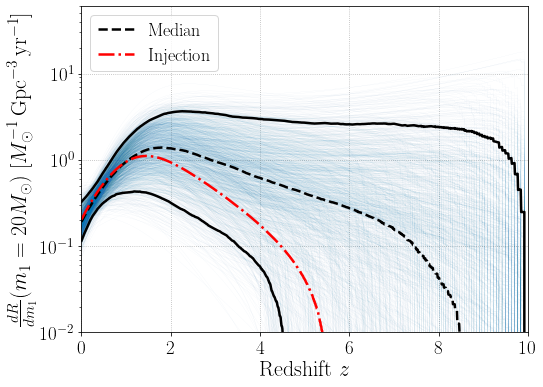

In [10]:
for ii in range(nTraces):
    plt.plot(zs,p_z_CBC_GWB_MD_O5_undetectable[ii], rasterized=True, color=my_palette[0],lw=0.15,alpha=0.1)
plt.plot(grid,np.quantile(p_z_CBC_GWB_MD_O5_undetectable,0.05,axis=0), rasterized=True, color='k', lw=2.5, alpha=1)
plt.plot(grid,np.quantile(p_z_CBC_GWB_MD_O5_undetectable,0.95,axis=0), rasterized=True, color='k',lw=2.5, alpha=1)
plt.plot(grid,np.median(p_z_CBC_GWB_MD_O5_undetectable,axis=0), rasterized=True, color='k', ls='dashed', lw=2.5, alpha=1, label="Median")
plt.plot(grid,R_inj_undet, rasterized=True, color='r', ls='dashdot', lw=2.5, alpha=1, label="Injection")
plt.yscale("log")
plt.xlabel("Redshift $z$", fontsize=22)
plt.xlim(0,10)
plt.ylim(1e-2,60)
plt.ylabel("$\\frac{dR}{dm_1}(m_1=20M_\\odot)~[M_\\odot^{-1}\,{\\rm Gpc}^{-3}\,{\\rm yr^{-1}}]$", fontsize=22)
plt.legend(fontsize = 18)
plt.xticks(fontsize=19)
plt.yticks(fontsize=19)
plt.grid(visible=True, ls='dotted')
plt.savefig("RateO5undetectable.pdf",dpi=500,bbox_inches='tight')

## Figure 6 - Right

In [11]:
sys.path.append("../code/")

In [12]:
from gwBackground import *

In [13]:
all_zs = np.linspace(0,10,200) #Should be 1000, just took it 10 for testing
omg = OmegaGW_BBH(2.1,100.,all_zs)

In [14]:
freqs = np.arange(10,1000,1)

Some of the runs were performed with a larger prior on the minimum time-delay parameter $t_d^{\rm min}$. To be consistent across all runs, we reject samples with a minimum time delay below $10^{-3}$. This corresponds to the minimum value displayed in the paper as well.

In [15]:
omega_array_undet_MD = np.zeros(nTraces, dtype=np.ndarray)
for ii,ind in enumerate(random_indices):
    if ii%100==0:
        print(ii)
    kappa = data_CBC_GWB_undetectable_O5['posterior/kappa'][()][mask_td_min_CBC_GWB_undetectable_O5][ii]
    Zmax = data_CBC_GWB_undetectable_O5['posterior/Zmax'][()][mask_td_min_CBC_GWB_undetectable_O5][ii]
    logRref = np.log10(data_CBC_GWB_undetectable_O5['posterior/R_ref'][()][mask_td_min_CBC_GWB_undetectable_O5][ii])
    td_min = data_CBC_GWB_undetectable_O5['posterior/td_min'][()][mask_td_min_CBC_GWB_undetectable_O5][ii]
    merger_rate_tmp, rate_02_tmp = R_norm_MD(grid, Zmax, kappa, td_min)
    rate_tmp = jnp.interp(all_zs, zs, merger_rate_tmp)
    omg.setProbs_plPeak(data_CBC_GWB_undetectable_O5['posterior/mMin'][()][mask_td_min_CBC_GWB_undetectable_O5][ii],data_CBC_GWB_undetectable_O5['posterior/mMax'][()][mask_td_min_CBC_GWB_undetectable_O5][ii],data_CBC_GWB_undetectable_O5['posterior/alpha'][()][mask_td_min_CBC_GWB_undetectable_O5][ii],data_CBC_GWB_undetectable_O5['posterior/mu_m1'][()][mask_td_min_CBC_GWB_undetectable_O5][ii],data_CBC_GWB_undetectable_O5['posterior/sig_m1'][()][mask_td_min_CBC_GWB_undetectable_O5][ii],10.**data_CBC_GWB_undetectable_O5['posterior/log_f_peak'][()][mask_td_min_CBC_GWB_undetectable_O5][ii],data_CBC_GWB_undetectable_O5['posterior/bq'][()][mask_td_min_CBC_GWB_undetectable_O5][ii], data_CBC_GWB_undetectable_O5['posterior/R_ref'][()][mask_td_min_CBC_GWB_undetectable_O5][ii], 10.**data_CBC_GWB_undetectable_O5['posterior/log_dmMax'][()][ii],10.**data_CBC_GWB_undetectable_O5['posterior/log_dmMin'][()][mask_td_min_CBC_GWB_undetectable_O5][ii])
    Omega_f = omg.eval(rate_tmp, rate_02_tmp, freqs)
    omega_array_undet_MD[ii] = Omega_f

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400


In [16]:
p_omega_array_undet_MD = np.zeros((nTraces,freqs.shape[0]))
for ii in range(nTraces):
    p_omega_array_undet_MD[ii,:] = omega_array_undet_MD[ii]

In [17]:
omega_f_undet = np.load("../mock_gwb_O5/Omega_undetectable_O5_MD.npy")
freqs_file_undet = np.load("../mock_gwb_O5/freqs_undetectable_O5.npy")

In [18]:
freqs_PI_O5 = np.array([])
omega_PI_O5 = np.array([])

with open('../input/O5_PI_curve.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=' ')
    line_count = 0
    for row in csv_reader:
        freqs_PI_O5 = np.append(freqs_PI_O5,float(row[0]))
        omega_PI_O5 = np.append(omega_PI_O5,float(row[1]))
        line_count += 1

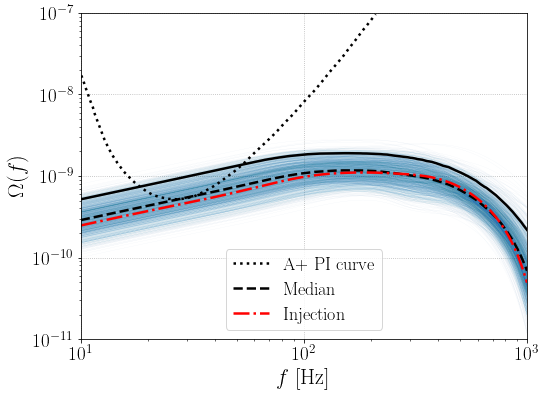

In [19]:
for ii in range(nTraces):
    plt.loglog(freqs, omega_array_undet_MD[ii], rasterized=True, color=my_palette[0],lw=0.15,alpha=0.1)
plt.loglog(freqs,np.quantile(p_omega_array_undet_MD,0.95,axis=0), rasterized=True, color='k',lw=2.5, alpha=1)
plt.loglog(freqs_PI_O5, omega_PI_O5, ls='dotted', rasterized=True, c='k', lw=2.5, label="A+ PI curve")
plt.loglog(freqs,np.median(p_omega_array_undet_MD,axis=0), rasterized=True, color='k', ls='dashed', lw=2.5, alpha=1, label="Median")
plt.loglog(freqs_file_undet, omega_f_undet, ls='dashdot', rasterized=True, c='r', lw=2.5, label="Injection")
plt.xlabel("$f$ [Hz]", fontsize=22)
plt.ylim(1e-11,1e-7)
plt.xlim(10,1000)
plt.ylabel("$\Omega(f)$", fontsize=22)
plt.legend(fontsize = 18)
plt.xticks(fontsize=19)
plt.yticks(fontsize=19)
plt.grid(visible=True, ls='dotted')
plt.savefig("OmegaO5undetectable.pdf",dpi=500,bbox_inches='tight')